In [1]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.grid()
    plt.legend()
    plt.show()
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b')
    plt.grid()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend()
    plt.show()

In [2]:
import math
import json
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from keras.models import Sequential
from keras.layers import Dense, Dropout

import machineLearningUtilities.dataPreparation as mlU
import qrQuery
from IF2.Crop import croppingProcess as cP
from IF2.Marker import markerProcess as maP
from IF2.Marker import markerAugmentation as mA
from IF2.Processing import colorTransformations as cT
from IF2.Processing import imageOperations as iO
from IF2.Processing import indAnalysis as inA
from IF2.Processing import preProcessing as pP
from IF2.ReadImage import readImage as rI
from IF2.Shows.showProcesses import showImage as show
from machineLearningUtilities import modelPerformance as mP
from machineLearningUtilities import nnUtils as nnU

Using TensorFlow backend.


Imported the machine learning utilities submodule
The module Crop has been successfuly imported from e:/unima/proyectos/imagefunctions/IF2/Crop
e:/unima/proyectos/imagefunctions/IF2/Crop
E:\Unima\Proyectos\AppProcessGab\Dataframe creation imported at location Dataframe creation


In [3]:
with open('../Database connections/connections.json') as jsonFile:
    connections = json.load(jsonFile)['connections']
zaptoConnection = connections['zapto']
zaptoImagesCollection = qrQuery.getCollection(
    zaptoConnection['URI'], zaptoConnection['databaseName'], zaptoConnection['collections']['markersCollectionName'])
markers = zaptoImagesCollection.find(
    {'diagnostic': {'$ne': None}}).sort('_id', -1).limit(0)
markersInfo = [[(iO.resizeFixed(rI.readb64(marker['image']))),
                {'diagnostic': marker['diagnostic'],
                 'name':  marker['marker'],
                 'qr': marker['QR'],
                 'count': marker['count'],
                 '_id': marker['_id']}
                ] for marker in markers]
markerImages = [info[0] for info in markersInfo]
markersInfo = [info[1] for info in markersInfo]
registerCount = len(markersInfo)


Procesando marcador 1 de 3168

Procesando marcador 2 de 3168

Procesando marcador 3 de 3168

Procesando marcador 4 de 3168

Procesando marcador 5 de 3168

Procesando marcador 6 de 3168

Procesando marcador 7 de 3168

Procesando marcador 8 de 3168

Procesando marcador 9 de 3168

Procesando marcador 10 de 3168

Procesando marcador 11 de 3168

Procesando marcador 12 de 3168

Procesando marcador 13 de 3168

Procesando marcador 14 de 3168

Procesando marcador 15 de 3168

Procesando marcador 16 de 3168

Procesando marcador 17 de 3168

Procesando marcador 18 de 3168

Procesando marcador 19 de 3168

Procesando marcador 20 de 3168

Procesando marcador 21 de 3168

Procesando marcador 22 de 3168

Procesando marcador 23 de 3168

Procesando marcador 24 de 3168

Procesando marcador 25 de 3168

Procesando marcador 26 de 3168

Procesando marcador 27 de 3168

Procesando marcador 28 de 3168

Procesando marcador 29 de 3168

Procesando marcador 30 de 3168

Procesando marcador 31 de 3168

Procesando marca

Procesando marcador 273 de 3168

Procesando marcador 274 de 3168

Procesando marcador 275 de 3168

Procesando marcador 276 de 3168

Procesando marcador 277 de 3168

Procesando marcador 278 de 3168

Procesando marcador 279 de 3168

Procesando marcador 280 de 3168

Procesando marcador 281 de 3168

Procesando marcador 282 de 3168

Procesando marcador 283 de 3168

Procesando marcador 284 de 3168

Procesando marcador 285 de 3168

Procesando marcador 286 de 3168

Procesando marcador 287 de 3168

Procesando marcador 288 de 3168

Procesando marcador 289 de 3168

Procesando marcador 290 de 3168

Procesando marcador 291 de 3168

Procesando marcador 292 de 3168

Procesando marcador 293 de 3168

Procesando marcador 294 de 3168

Procesando marcador 295 de 3168

Procesando marcador 296 de 3168

Procesando marcador 297 de 3168

Procesando marcador 298 de 3168

Procesando marcador 299 de 3168

Procesando marcador 300 de 3168

Procesando marcador 301 de 3168

Procesando marcador 302 de 3168

Procesando

Procesando marcador 573 de 3168

Procesando marcador 574 de 3168

Procesando marcador 575 de 3168

Procesando marcador 576 de 3168

Procesando marcador 577 de 3168

Procesando marcador 578 de 3168

Procesando marcador 579 de 3168

Procesando marcador 580 de 3168

Procesando marcador 581 de 3168

Procesando marcador 582 de 3168

Procesando marcador 583 de 3168

Procesando marcador 584 de 3168

Procesando marcador 585 de 3168

Procesando marcador 586 de 3168

Procesando marcador 587 de 3168

Procesando marcador 588 de 3168

Procesando marcador 589 de 3168

Procesando marcador 590 de 3168

Procesando marcador 591 de 3168

Procesando marcador 592 de 3168

Procesando marcador 593 de 3168

Procesando marcador 594 de 3168

Procesando marcador 595 de 3168

Procesando marcador 596 de 3168

Procesando marcador 597 de 3168

Procesando marcador 598 de 3168

Procesando marcador 599 de 3168

Procesando marcador 600 de 3168

Procesando marcador 601 de 3168

Procesando marcador 602 de 3168

Procesando

Procesando marcador 872 de 3168

Procesando marcador 873 de 3168

Procesando marcador 874 de 3168

Procesando marcador 875 de 3168

Procesando marcador 876 de 3168

Procesando marcador 877 de 3168

Procesando marcador 878 de 3168

Procesando marcador 879 de 3168

Procesando marcador 880 de 3168

Procesando marcador 881 de 3168

Procesando marcador 882 de 3168

Procesando marcador 883 de 3168

Procesando marcador 884 de 3168

Procesando marcador 885 de 3168

Procesando marcador 886 de 3168

Procesando marcador 887 de 3168

Procesando marcador 888 de 3168

Procesando marcador 889 de 3168

Procesando marcador 890 de 3168

Procesando marcador 891 de 3168

Procesando marcador 892 de 3168

Procesando marcador 893 de 3168

Procesando marcador 894 de 3168

Procesando marcador 895 de 3168

Procesando marcador 896 de 3168

Procesando marcador 897 de 3168

Procesando marcador 898 de 3168

Procesando marcador 899 de 3168

Procesando marcador 900 de 3168

Procesando marcador 901 de 3168

Procesando

Procesando marcador 1119 de 3168

Procesando marcador 1120 de 3168

Procesando marcador 1121 de 3168

Procesando marcador 1122 de 3168

Procesando marcador 1123 de 3168

Procesando marcador 1124 de 3168

Procesando marcador 1125 de 3168

Procesando marcador 1126 de 3168

Procesando marcador 1127 de 3168

Procesando marcador 1128 de 3168

Procesando marcador 1129 de 3168

Procesando marcador 1130 de 3168

Procesando marcador 1131 de 3168

Procesando marcador 1132 de 3168

Procesando marcador 1133 de 3168

Procesando marcador 1134 de 3168

Procesando marcador 1135 de 3168

Procesando marcador 1136 de 3168

Procesando marcador 1137 de 3168

Procesando marcador 1138 de 3168

Procesando marcador 1139 de 3168

Procesando marcador 1140 de 3168

Procesando marcador 1141 de 3168

Procesando marcador 1142 de 3168

Procesando marcador 1143 de 3168

Procesando marcador 1144 de 3168

Procesando marcador 1145 de 3168

Procesando marcador 1146 de 3168

Procesando marcador 1147 de 3168

Procesando mar


Procesando marcador 1366 de 3168

Procesando marcador 1367 de 3168

Procesando marcador 1368 de 3168

Procesando marcador 1369 de 3168

Procesando marcador 1370 de 3168

Procesando marcador 1371 de 3168

Procesando marcador 1372 de 3168

Procesando marcador 1373 de 3168

Procesando marcador 1374 de 3168

Procesando marcador 1375 de 3168

Procesando marcador 1376 de 3168

Procesando marcador 1377 de 3168

Procesando marcador 1378 de 3168

Procesando marcador 1379 de 3168

Procesando marcador 1380 de 3168

Procesando marcador 1381 de 3168

Procesando marcador 1382 de 3168

Procesando marcador 1383 de 3168

Procesando marcador 1384 de 3168

Procesando marcador 1385 de 3168

Procesando marcador 1386 de 3168

Procesando marcador 1387 de 3168

Procesando marcador 1388 de 3168

Procesando marcador 1389 de 3168

Procesando marcador 1390 de 3168

Procesando marcador 1391 de 3168

Procesando marcador 1392 de 3168

Procesando marcador 1393 de 3168

Procesando marcador 1394 de 3168

Procesando ma

Procesando marcador 1643 de 3168

Procesando marcador 1644 de 3168

Procesando marcador 1645 de 3168

Procesando marcador 1646 de 3168

Procesando marcador 1647 de 3168

Procesando marcador 1648 de 3168

Procesando marcador 1649 de 3168

Procesando marcador 1650 de 3168

Procesando marcador 1651 de 3168

Procesando marcador 1652 de 3168

Procesando marcador 1653 de 3168

Procesando marcador 1654 de 3168

Procesando marcador 1655 de 3168

Procesando marcador 1656 de 3168

Procesando marcador 1657 de 3168

Procesando marcador 1658 de 3168

Procesando marcador 1659 de 3168

Procesando marcador 1660 de 3168

Procesando marcador 1661 de 3168

Procesando marcador 1662 de 3168

Procesando marcador 1663 de 3168

Procesando marcador 1664 de 3168

Procesando marcador 1665 de 3168

Procesando marcador 1666 de 3168

Procesando marcador 1667 de 3168

Procesando marcador 1668 de 3168

Procesando marcador 1669 de 3168

Procesando marcador 1670 de 3168

Procesando marcador 1671 de 3168

Procesando mar

Procesando marcador 1936 de 3168

Procesando marcador 1937 de 3168

Procesando marcador 1938 de 3168

Procesando marcador 1939 de 3168

Procesando marcador 1940 de 3168

Procesando marcador 1941 de 3168

Procesando marcador 1942 de 3168

Procesando marcador 1943 de 3168

Procesando marcador 1944 de 3168

Procesando marcador 1945 de 3168

Procesando marcador 1946 de 3168

Procesando marcador 1947 de 3168

Procesando marcador 1948 de 3168

Procesando marcador 1949 de 3168

Procesando marcador 1950 de 3168

Procesando marcador 1951 de 3168

Procesando marcador 1952 de 3168

Procesando marcador 1953 de 3168

Procesando marcador 1954 de 3168

Procesando marcador 1955 de 3168

Procesando marcador 1956 de 3168

Procesando marcador 1957 de 3168

Procesando marcador 1958 de 3168

Procesando marcador 1959 de 3168

Procesando marcador 1960 de 3168

Procesando marcador 1961 de 3168

Procesando marcador 1962 de 3168

Procesando marcador 1963 de 3168

Procesando marcador 1964 de 3168

Procesando mar

Procesando marcador 2214 de 3168

Procesando marcador 2215 de 3168

Procesando marcador 2216 de 3168

Procesando marcador 2217 de 3168

Procesando marcador 2218 de 3168

Procesando marcador 2219 de 3168

Procesando marcador 2220 de 3168

Procesando marcador 2221 de 3168

Procesando marcador 2222 de 3168

Procesando marcador 2223 de 3168

Procesando marcador 2224 de 3168

Procesando marcador 2225 de 3168

Procesando marcador 2226 de 3168

Procesando marcador 2227 de 3168

Procesando marcador 2228 de 3168

Procesando marcador 2229 de 3168

Procesando marcador 2230 de 3168

Procesando marcador 2231 de 3168

Procesando marcador 2232 de 3168

Procesando marcador 2233 de 3168

Procesando marcador 2234 de 3168

Procesando marcador 2235 de 3168

Procesando marcador 2236 de 3168

Procesando marcador 2237 de 3168

Procesando marcador 2238 de 3168

Procesando marcador 2239 de 3168

Procesando marcador 2240 de 3168

Procesando marcador 2241 de 3168

Procesando marcador 2242 de 3168

Procesando mar

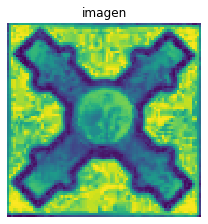

In [78]:
fullFeatures = []
labels = []
for i, (markerOriginal, info) in enumerate(zip(markerImages[:2400], markersInfo)):
    print(f'\nProcesando marcador {i+1} de {registerCount}')
    markerOriginal = cT.BGR2RGB(markerOriginal)
    markerHist = pP.adapHistogramEq(markerOriginal, 5, (3, 3))
    markersAug = mA.augmentMarker(markerHist)
    diagnostic = inA.fixDiagnostic(info['diagnostic'])
    if diagnostic is None:
        continue
    for markerAug in markersAug:
        markerGrayScale = cT.RGB2gray(markerHist)
        marker1D = markerGrayScale.reshape((1, -1)).ravel()/255
        fullFeatures.append(marker1D)
        labels.append(diagnostic)
show(markerGrayScale)

In [79]:
from sklearn.utils import shuffle
fullFeatures = pd.DataFrame(fullFeatures)
labels = pd.DataFrame(labels)
dataWithLabels = pd.concat([fullFeatures, labels], axis=1)
dataShuffled = shuffle(dataWithLabels)

In [80]:
X = dataShuffled.iloc[:,:-1]
y = dataShuffled.iloc[:, -1]
X_train, X_test, y_train, y_test = mlU.splitData(X, y, seed=42)
X_test.shape

(3338, 8100)

In [81]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
lr_clf = LogisticRegression(max_iter=10000, random_state=42)
lr_clf.fit(X_train, y_train)

C:\Users\gabriel.michel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [82]:
# I have a skewed set, so this is not reliable
#cross_val_score(sgd_clf, X_train,  y_train, cv=3, scoring='accuracy')
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [83]:
metrics.confusion_matrix(y_train, y_train_pred)

array([[5903,   38],
       [  11, 7398]], dtype=int64)

In [78]:
y_train_pred = cross_val_predict(lr_clf, X_train, y_train, cv=3)
metrics.confusion_matrix(y_train, y_train_pred)

C:\Users\gabriel.michel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gabriel.michel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gabriel.michel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[354,  23],
       [ 13, 410]], dtype=int64)

In [79]:
precission = metrics.precision_score(y_train, y_train_pred)
recall = metrics.recall_score(y_train, y_train_pred)
f1 = metrics.f1_score(y_train, y_train_pred)
print(precission, recall, f1)

0.9468822170900693 0.9692671394799054 0.9579439252336447


In [86]:
y_scores = cross_val_predict(lr_clf, X_train, y_train, cv=3, method='decision_function')

C:\Users\gabriel.michel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gabriel.michel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gabriel.michel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plot_precision_vs_recall(precisions, recalls)
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_scores)
plot_roc_curve(fpr, tpr)
print(metrics.roc_auc_score(y_train, y_scores))

NameError: name 'y_scores' is not defined

In [69]:
#%% new preds
picturesPath = '../assetsForTests/neg_finger_blood/mid/'
picturesFullPath = [picturesPath+name for name in os.listdir(picturesPath) if name.endswith('.jpg') or name.endswith('.png') or name.endswith('.jpeg') or name.endswith('.JPG')]
pictures = [iO.resizeImg(rI.readLocal(path), 728) for path in picturesFullPath]
#%%

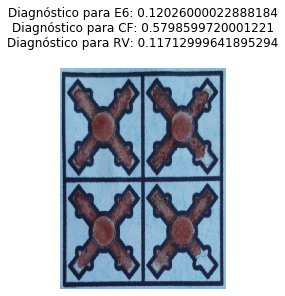

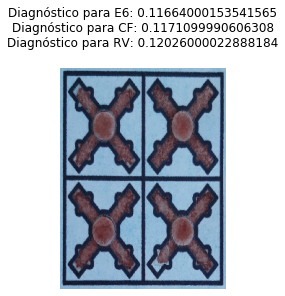

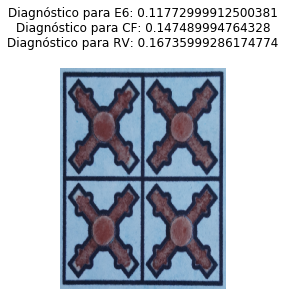

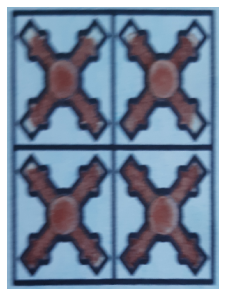

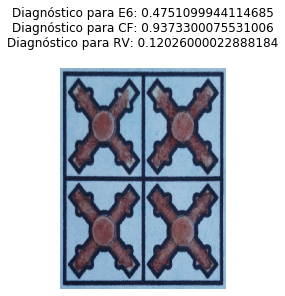

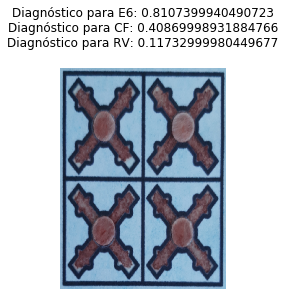

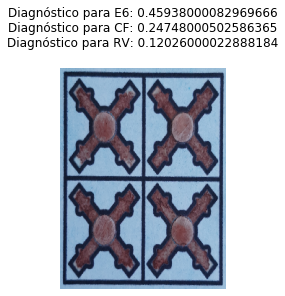

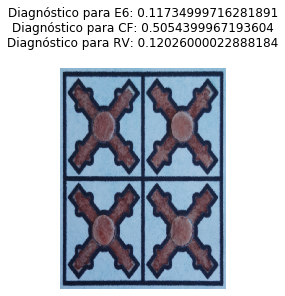

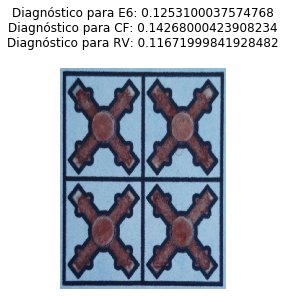

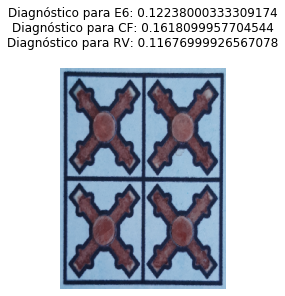

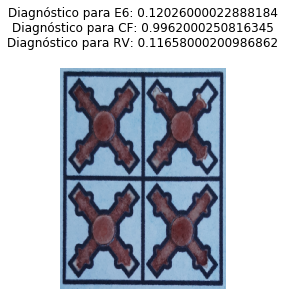

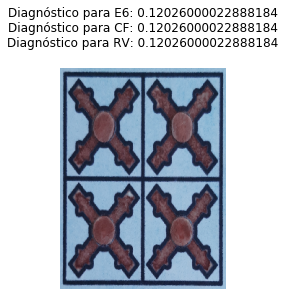

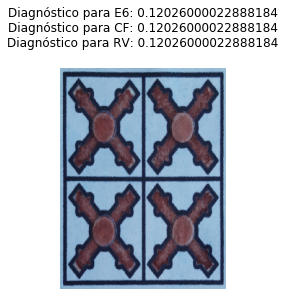

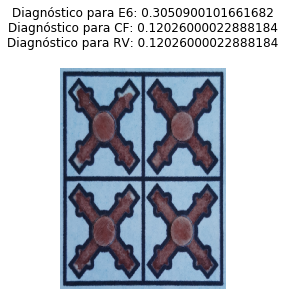

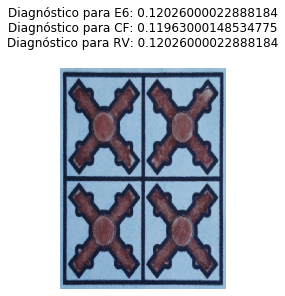

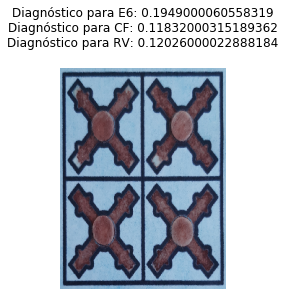

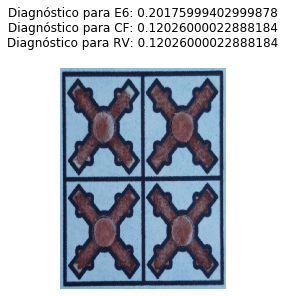

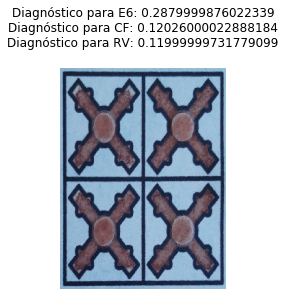

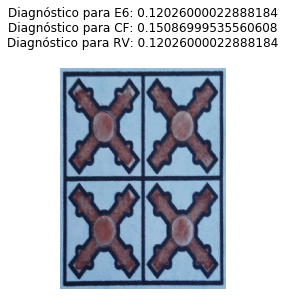

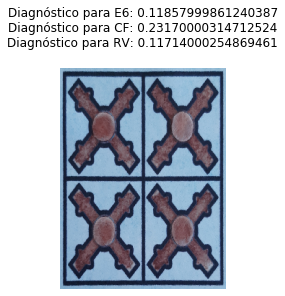

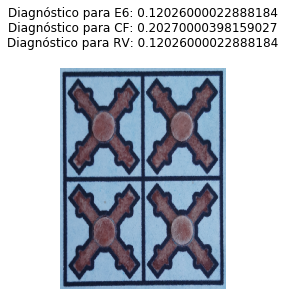

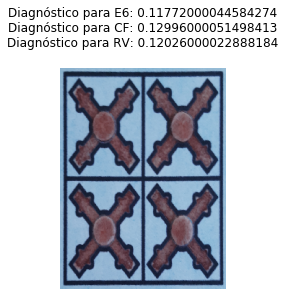

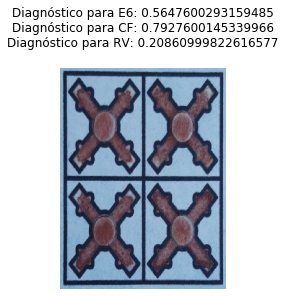

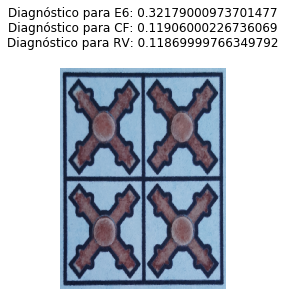

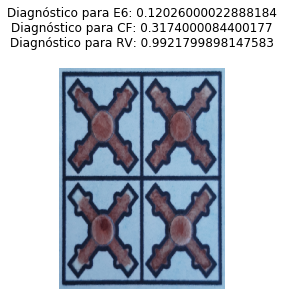

In [88]:
markerNames = ['E6', 'CF', 'RV']
columns = ['fileName'] + markerNames
fullData = []
for i, (picture, name) in enumerate(zip(pictures, os.listdir(picturesPath))):
    picture = cT.BGR2RGB(picture)
    testArea = cP.getTestArea(picture)
    markers = cP.getMarkers(testArea)[:-1]
    diags= []
    for marker in markers: 
        markerHist = pP.adapHistogramEq(marker, 5, (3, 3))
        markerGray = cT.RGB2gray(markerHist)
        marker1d = markerGray.reshape((1, -1))/255
        #diagProb = sgd_clf.predict_proba(marker1d)[0][1]
        diag = model.predict(marker1d)[0][0]
        diags.append(diag)
        #show(markerGray)
    diagStrings = ''.join([f'Diagnóstico para {marker}: {round(diag, 5)}\n' for marker, diag in zip(markerNames, diags)])
    data = [name] + diags
    fullData.append(data)
    show(testArea, title=diagStrings,figSize=(4,4))
testDf2 = pd.DataFrame(fullData, columns=columns)

In [84]:
import keras
alpha = 1000
nFeatures = len(X.columns)
activations = ['relu', 'relu']
l1 = None
l2 = 0.001
dropout = 0.0
model = Sequential()
model.add(Dense(15, input_dim=nFeatures, init='uniform', activation='relu'))
model.add(Dense(12, init='uniform', activation='relu', use_bias=True,
                      kernel_regularizer=keras.regularizers.l2(l2),
                      bias_regularizer=keras.regularizers.l2(l2)))
model.add(Dense(10,  init='uniform', activation='relu',use_bias=True,
                      kernel_regularizer=keras.regularizers.l2(l2),
                      bias_regularizer=keras.regularizers.l2(l2)))

model.add(Dense(1, init='uniform', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'binary_crossentropy'])
print(nFeatures)

8100


C:\Users\gabriel.michel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=8100, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
C:\Users\gabriel.michel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="relu", use_bias=True, kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\gabriel.michel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", use_bias=True, kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., kernel_initializer="uniform")`
  from ipykernel import kernelapp as app
C:\Users\gabriel.michel\AppData\Local\Continuum\anaconda3\lib\site

In [85]:
history = model.fit(X_train, y_train, epochs=10,batch_size=400, verbose=2, validation_data=(X_test, y_test))

Train on 13350 samples, validate on 3338 samples
Epoch 1/10
 - 4s - loss: 0.6885 - accuracy: 0.5550 - binary_crossentropy: 0.6883 - val_loss: 0.6850 - val_accuracy: 0.5527 - val_binary_crossentropy: 0.6849
Epoch 2/10
 - 4s - loss: 0.6769 - accuracy: 0.5550 - binary_crossentropy: 0.6768 - val_loss: 0.6533 - val_accuracy: 0.5527 - val_binary_crossentropy: 0.6532
Epoch 3/10
 - 4s - loss: 0.5711 - accuracy: 0.6631 - binary_crossentropy: 0.5706 - val_loss: 0.4966 - val_accuracy: 0.8478 - val_binary_crossentropy: 0.4957
Epoch 4/10
 - 4s - loss: 0.4537 - accuracy: 0.8563 - binary_crossentropy: 0.4525 - val_loss: 0.4484 - val_accuracy: 0.8811 - val_binary_crossentropy: 0.4468
Epoch 5/10
 - 3s - loss: 0.4120 - accuracy: 0.8837 - binary_crossentropy: 0.4102 - val_loss: 0.4001 - val_accuracy: 0.8820 - val_binary_crossentropy: 0.3980
Epoch 6/10
 - 4s - loss: 0.3640 - accuracy: 0.8976 - binary_crossentropy: 0.3615 - val_loss: 0.3567 - val_accuracy: 0.9017 - val_binary_crossentropy: 0.3538
Epoch 7/1

In [86]:
scores = model.evaluate(X_test, y_test) 
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3338/3338 [==============================] - 1s 173us/step
accuracy: 92.21%


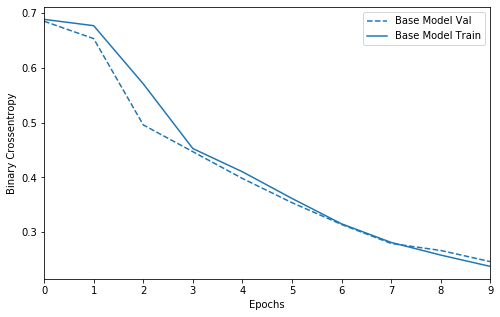

In [87]:
nnU.plot_history([('Base model', history)])

In [103]:
model.predict(X_test[522].reshape(1,-1))


array([[0.78029656]], dtype=float32)

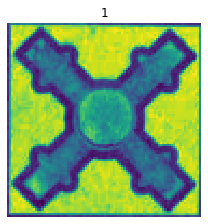

In [106]:
show(X_test[522].reshape(90,90), title=y_test[522])